In [1]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack 2.0 - Tracking multiple particles with a U-net

This tutorial demonstrates how to track multiple particles using a U-net with DeepTrack 2.0.

The U-net receives as input an image that may or may not contain particles and outputs an image whose pixels represent the probability that there is a particle nearby. Specifically, each pixel has a value between 0 (high confidence that there is no particle close by) and 1 (high confidence that there is a nearby particle).

This tutorial should be perused after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particle

For this example, we consider point particles (point light scatterers). A point particle is an instance of the class `PointParticle`, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [3]:
particle = dt.PointParticle(                                         
    intensity=100,
    position=lambda: np.random.rand(2) * 256
)

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Fluorescence`, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [4]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.4,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 256, 256)
)

## 4. Define noises

We introduce two sources of noise (see also [noises_example](../examples/noises_example.ipynb)):
1. A background random offset between 0 and 1.
2. A Poisson noise with a random SNR between 3 and 10.

In [5]:
offset = dt.Add(
    value=lambda: np.random.rand()*1
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 3,
    background=offset.value
)

## 5. Define the image features

We want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

In [6]:
num_particles = lambda: np.random.randint(1, 11)

image_features = fluorescence_microscope(particle^num_particles) >> offset >> poisson_noise >> dt.NormalizeMinMax()

## 6. Plot example images

Now, we visualize some example images. At each iteration, we call the method `.update()` to refresh the random features in the image (particle number, particle positions, offset level, and Poisson noise). Afterwards we call the method `.plot()` to generate and display the image.

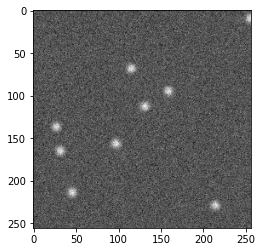

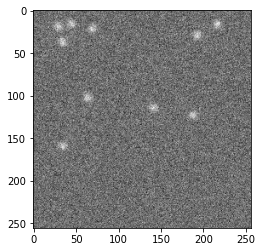

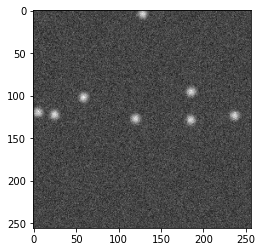

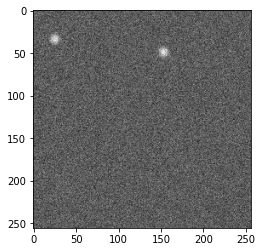

In [7]:
for i in range(4):
    image_features.update()
    output_image = image_features.plot(cmap="gray")

## 9. Define the neural network model

The neural network architecture used is a U-Net, which is a fully convolutional model used for image-to-image transformations. We create this model by calling the function `unet` (see also [models_example](../examples/models_example.ipynb)).

Since the desired output is a binary image, we will be using crossentropy as loss. Furthermore, since the target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), we weight the loss such that false negatives are penalized ten times more than the false positives. 

The model can be customized by passing the following arguments:

* `input_shape`: Size of the images to be analyzed. The first two values can be set to `None` to allow arbitrary sizes.

* `conv_layers_dimensions`: Number of convolutions in each convolutional layer during down-
    and upsampling.
    
* `base_conv_layers_dimensions`: Number of convolutions in each convolutional layer at the base
    of the unet, where the image is the most downsampled.

* `output_conv_layers_dimensions`: Number of convolutions in each convolutional layer after the
    upsampling.
    
* `steps_per_pooling`: Number of convolutional layers between each pooling and upsampling
    step.

* `number_of_outputs`: Number of convolutions in output layer.

* `output_activation`: The activation function of the output.

* `loss`: The loss function of the network.

* `optimizer`: The the optimizer used for training.

* `metrics`: Additional metrics to evaulate during training.

In [8]:
model = dt.models.AutoMultiTracker(
    input_shape=(256, 256, 1),
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 254, 254, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 127, 127, 16) 0           activation[0][0]                 
______________________________________________________________________________________________

## 10. Train the model

The model is trained by calling `.fit()`. This will take a few minutes.

In [9]:
# g = model.data_generator(image_features, max_data_size=1000, min_data_size=50, batch_size=8)

# with g:
#     a = g[0][1]
    
#     for b in a:
#         print(b, b[:6].reshape((2,3))[:2, :2])

model.fit(image_features, epochs=100, batch_size=8)

Generating 415 / 400 samples before starting training
Epoch 1/100
415/415 [==============================] - 18s 33ms/step - loss: 8.0011
Epoch 2/100
415/415 [==============================] - 16s 38ms/step - loss: 8.0000
Epoch 3/100
415/415 [==============================] - 15s 36ms/step - loss: 8.0000
Epoch 4/100
415/415 [==============================] - 11s 27ms/step - loss: 8.0000
Epoch 5/100
156/415 [==========>...................] - ETA: 9s - loss: 8.0000

KeyboardInterrupt: 

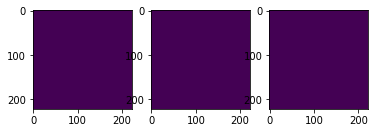

In [10]:
out = model.predict(image_features.update().resolve()[np.newaxis])[0]

plt.subplot(1, 3, 1)
plt.imshow(out[..., 0])
plt.subplot(1, 3, 2)
plt.imshow(out[..., 1])
plt.subplot(1, 3, 3)
plt.imshow(out[..., 2])
plt.show()

In [13]:
out[:, :, 1]

array([[0.00584369, 0.00584369, 0.00584369, ..., 0.00584369, 0.00584369,
        0.00584369],
       [0.00584369, 0.00584369, 0.00584369, ..., 0.00584369, 0.00584369,
        0.00584369],
       [0.00584369, 0.00584369, 0.00584369, ..., 0.00584369, 0.00584369,
        0.00584369],
       ...,
       [0.00584369, 0.00584369, 0.00584369, ..., 0.00584369, 0.00584369,
        0.00584369],
       [0.00584369, 0.00584369, 0.00584369, ..., 0.00584369, 0.00584369,
        0.00584369],
       [0.00584369, 0.00584369, 0.00584369, ..., 0.00584369, 0.00584369,
        0.00584369]], dtype=float32)

## 11. Visualize the model performance

Finally, we evaluate the model performance by showing the model output besides the input image and the target image.

In [ ]:
# generator[0] grabs a single batch from the generator
input_image, target_image = generator[0]

for i in range(input_image.shape[0]):
    
    predicted_image = model.predict(input_image)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(input_image[i, :, :, 0]), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(predicted_image[i, :, :, 0]), cmap="gray")
    plt.title("Predicted Image")
    
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(target_image[i, :, :, 0] > 0.5), cmap="gray")
    plt.title("Target image")

    plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_addons
from deeptrack.losses import softmax
K = tf.keras.backend

P = np.ones((2, 32, 32, 3), dtype=np.float32)
P[1] = -1
T = np.array([[1., 0, 0, 0, 1, 0, 0, 0], [-1, 0, 1, 0, -1, 1, 0, 0]], dtype=np.float32)


transform = K.reshape(T[:, :6], (-1, 2, 3))

offset_vector = transform[:, :, 2]
transformation_matrix = transform[:, :2, :2]

# For broadcasting

offset_vector = K.reshape(offset_vector, (-1, 1, 1, 2))
transformation_matrix = K.reshape(transformation_matrix, (-1, 1, 1, 2, 2))

# Transforms and broadcasts the
transformed_origin = tf.linalg.matvec(transformation_matrix, P[:1, ..., :2])

# Transforms all prediced images to match the first image
transformed_field = tensorflow_addons.image.transform(transformed_origin, T, fill_mode="wrap")

error = offset_vector - (P[..., :2] - transformed_field)

error_tot = (
    error
    * softmax(P[:, :, :, 2:3], axis=(1, 2, 3))
    * K.cast_to_floatx(K.shape(error)[1] * K.shape(error)[2])
)
# return error

In [ ]:
transformed_field.numpy()[1, ..., 1]